In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer

import joblib


In [104]:
# Load data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTbg5WVW6W3c8SPNUGc3A3AL-AG32TPEQGpdzARfNICMsLFI0LQj0jporhsLCeVhkN5AoRsTkn08AYl/pub?output=csv'
df = pd.read_csv(url)

In [105]:
# Tampilkan 5 baris pertama
df.head()


,TransactionID,AccountID,TransactionAmount,PreviousTransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,TransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70.0,Doctor,81.0,1.0,5112.21,2024-11-04 8:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68.0,Doctor,141.0,1.0,13758.91,2024-11-04 8:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19.0,Student,56.0,1.0,1122.35,2024-11-04 8:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26.0,Student,25.0,1.0,8569.06,2024-11-04 8:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,NaN,Student,198.0,1.0,7429.40,2024-11-04 8:06:39


In [106]:
# Informasi dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2508 non-null   object 
 1   AccountID                2516 non-null   object 
 2   TransactionAmount        2511 non-null   float64
 3   PreviousTransactionDate  2509 non-null   object 
 4   TransactionType          2507 non-null   object 
 5   Location                 2507 non-null   object 
 6   DeviceID                 2507 non-null   object 
 7   IP Address               2517 non-null   object 
 8   MerchantID               2514 non-null   object 
 9   Channel                  2510 non-null   object 
 10  CustomerAge              2519 non-null   float64
 11  CustomerOccupation       2514 non-null   object 
 12  TransactionDuration      2511 non-null   float64
 13  LoginAttempts            2516 non-null   float64
 14  AccountBalance          

In [107]:
# Statistik deskriptif
df.describe()


,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2511.000000,2519.000000,2511.000000,2516.000000,2510.000000
mean,297.656468,44.678444,119.422939,1.121622,5113.438124
std,292.230367,17.837359,70.078513,0.594469,3897.975861
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.310000,27.000000,63.000000,1.000000,1504.727500
50%,211.360000,45.000000,112.000000,1.000000,4734.110000
75%,413.105000,59.000000,161.000000,1.000000,7672.687500
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


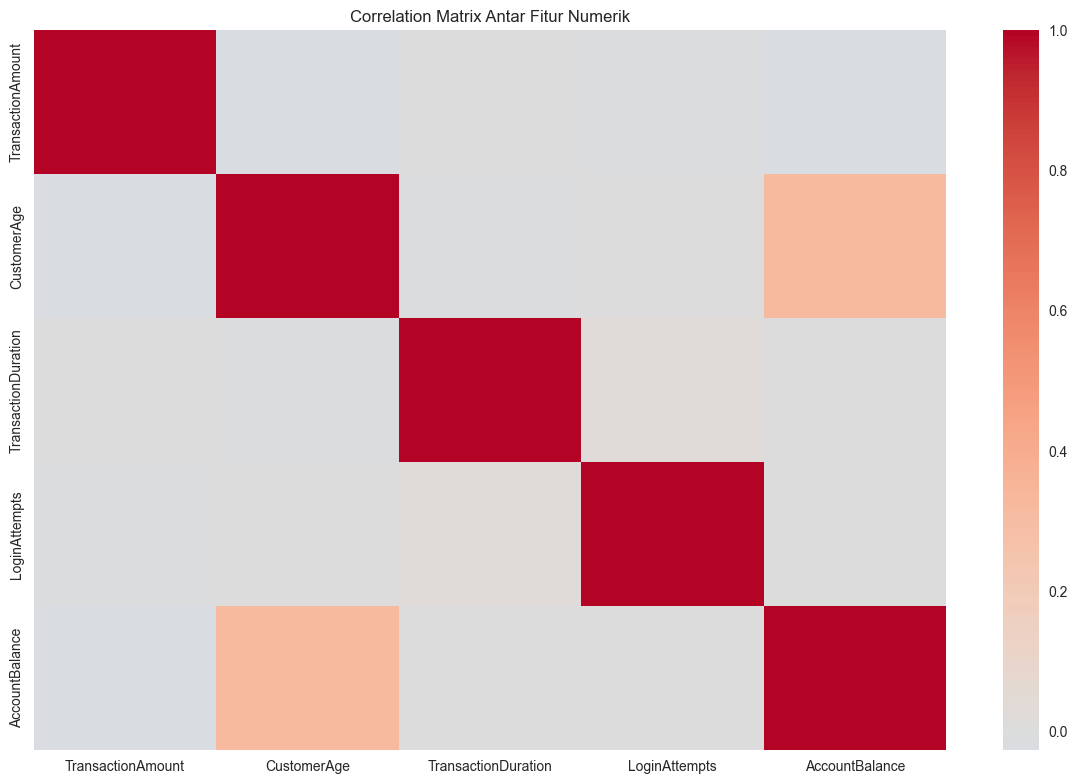

In [108]:
# Korelasi antar fitur numerik
plt.figure(figsize=(12, 8))
sns.heatmap(
    df.corr(numeric_only=True),
    cmap='coolwarm',
    center=0,
    annot=False
)
plt.title("Correlation Matrix Antar Fitur Numerik")
plt.tight_layout()
plt.show()

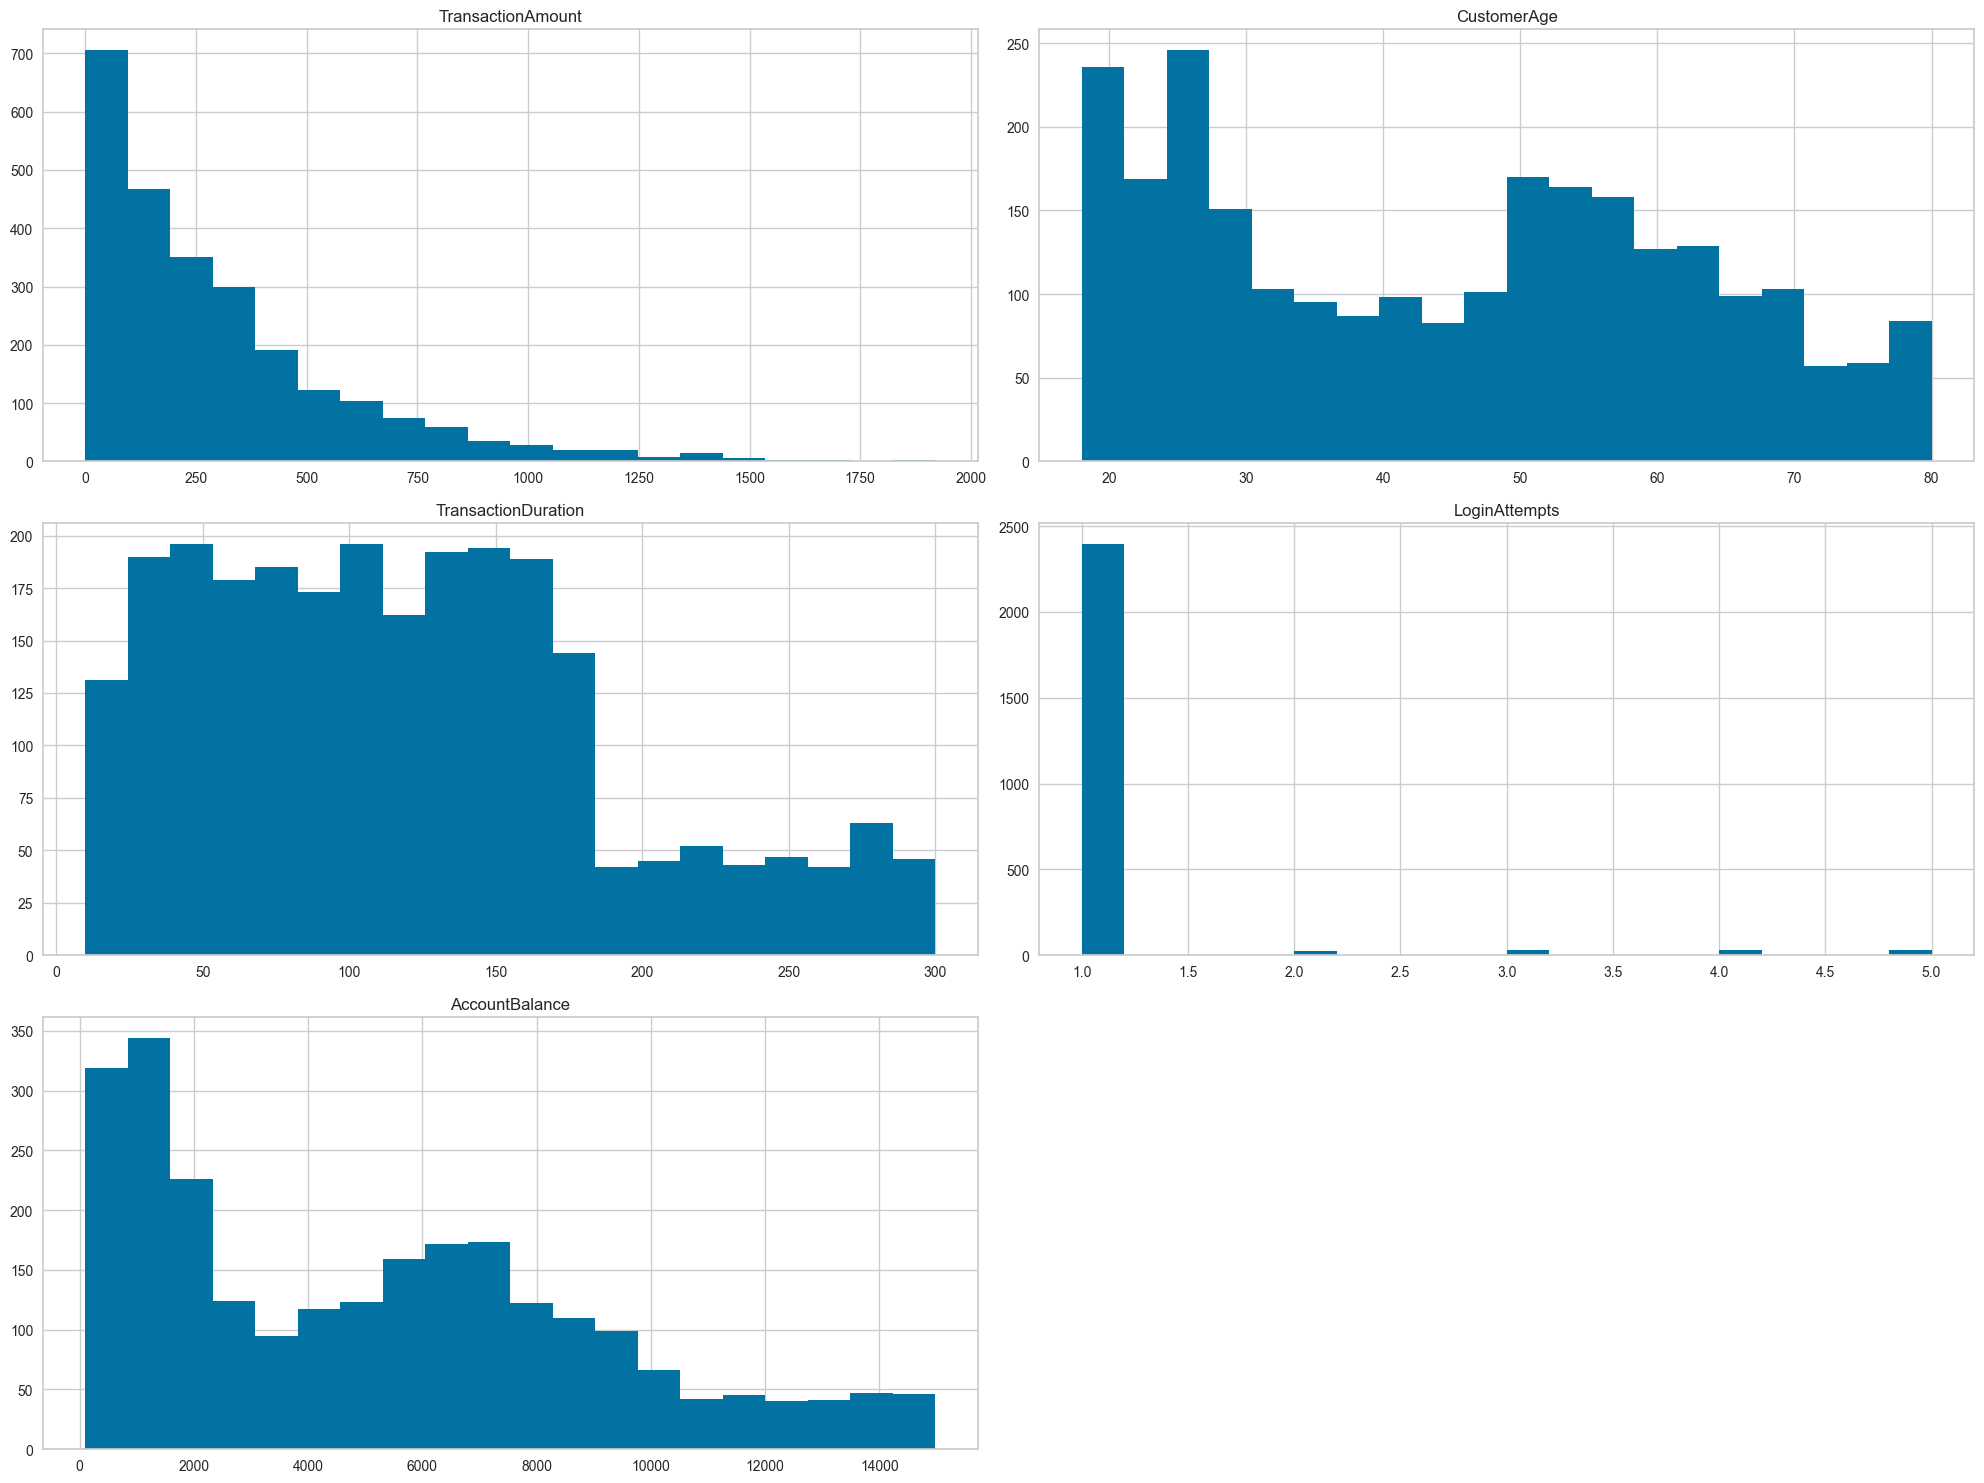

In [109]:
# Histogram untuk semua kolom numerik
df.select_dtypes(include=['int64', 'float64']).hist(figsize=(20, 15), bins=20)
plt.tight_layout()
plt.show()


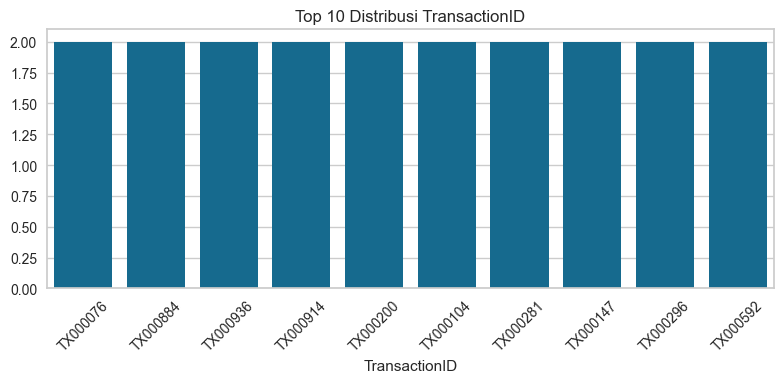

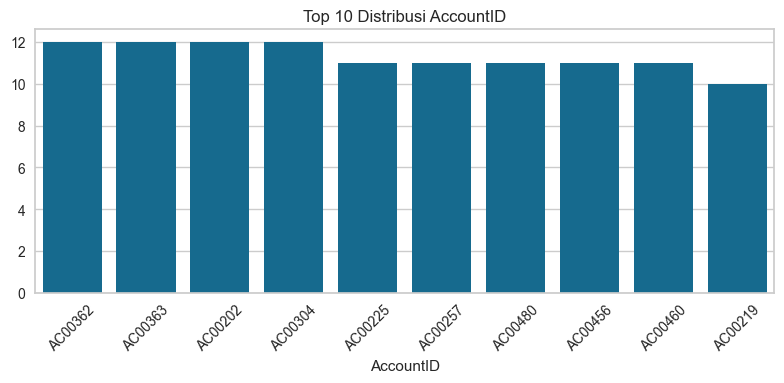

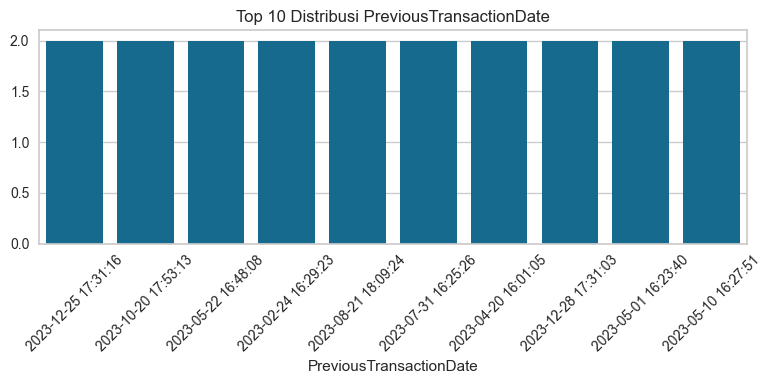

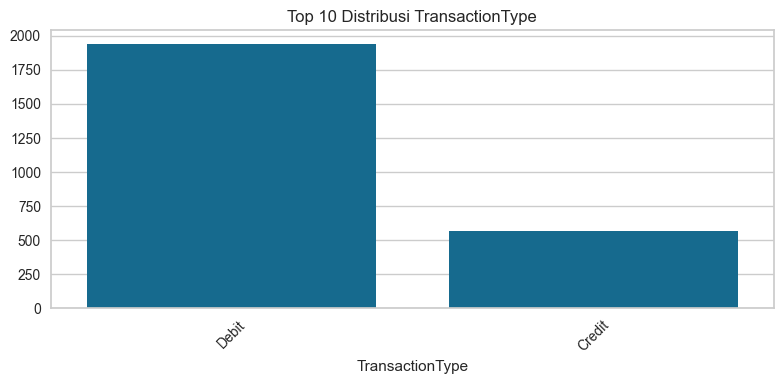

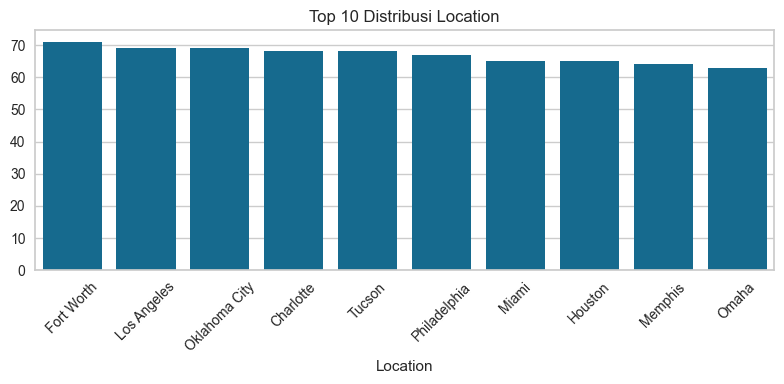

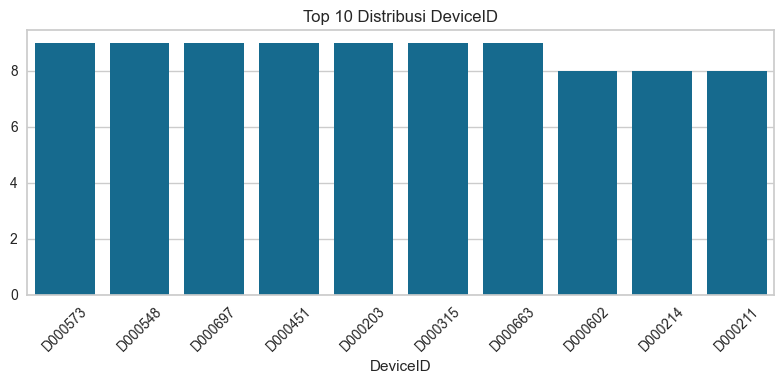

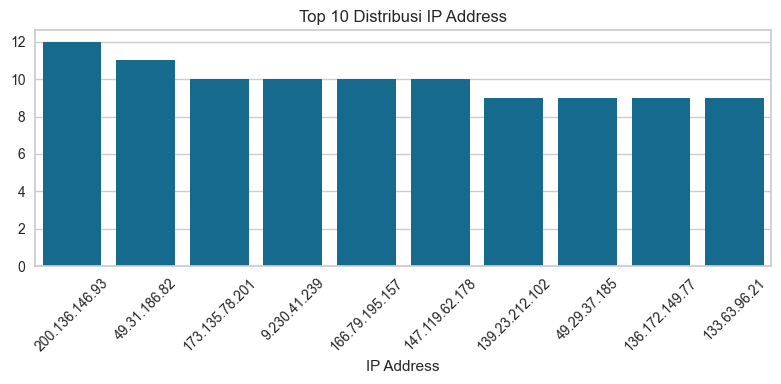

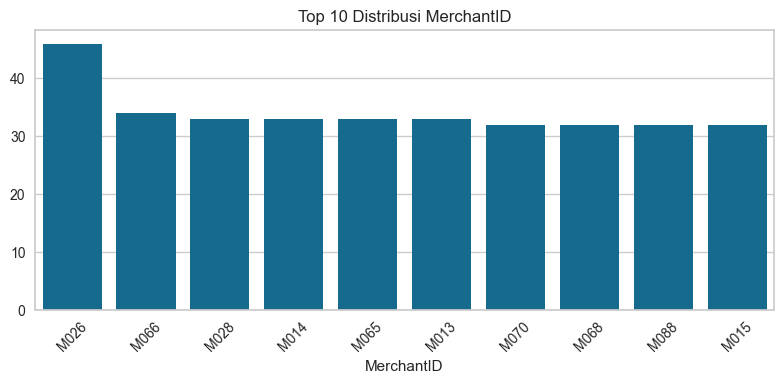

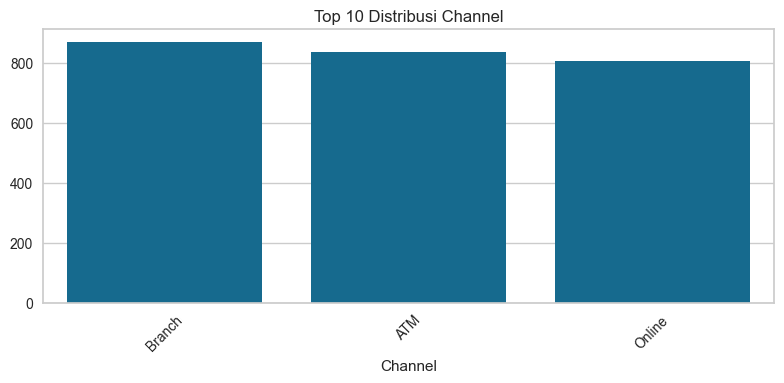

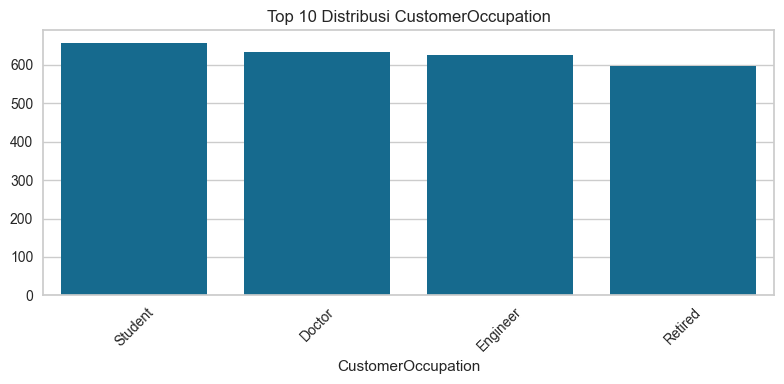

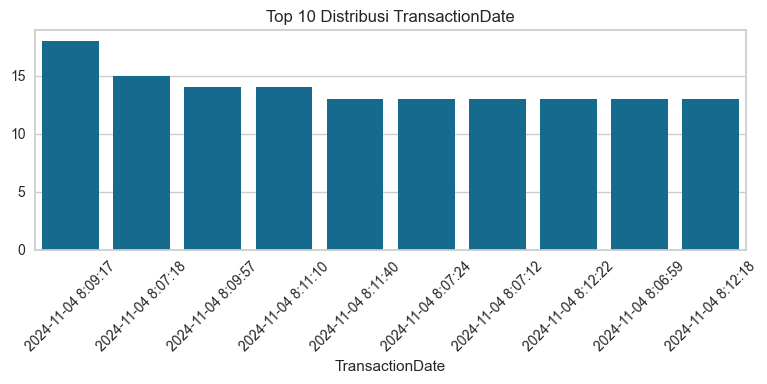

In [ ]:
# Visualisasi kategorikal (Top 10 kategori saja)
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    top_categories = df[col].value_counts().head(10)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(
        x=top_categories.index,
        y=top_categories.values
    )
    plt.title(f'Top 10 Distribusi {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


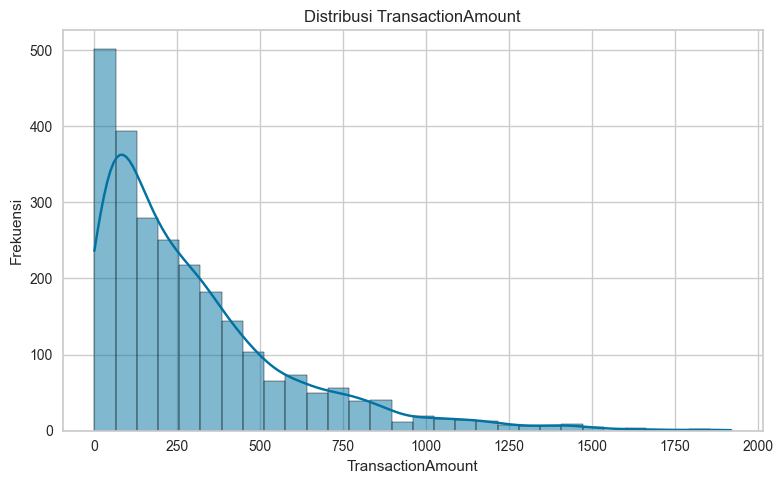

In [111]:
# Distribusi TransactionAmount
plt.figure(figsize=(8, 5))
sns.histplot(df['TransactionAmount'], bins=30, kde=True)
plt.title("Distribusi TransactionAmount")
plt.xlabel("TransactionAmount")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()


In [112]:
# Cek missing value
df.isnull().sum()


TransactionID              29
AccountID                  21
TransactionAmount          26
PreviousTransactionDate    28
TransactionType            30
Location                   30
DeviceID                   30
IP Address                 20
MerchantID                 23
Channel                    27
CustomerAge                18
CustomerOccupation         23
TransactionDuration        26
LoginAttempts              21
AccountBalance             27
TransactionDate            24
dtype: int64

In [113]:
# Cek data duplikat
df.duplicated().sum()


np.int64(21)

In [114]:
# Hapus baris dengan nilai kosong
df = df.dropna()

# Hapus data duplikat
df = df.drop_duplicates()


In [115]:
# Drop kolom ID, Date, dan IP Address
df = df.drop(columns=[
    'TransactionID',
    'AccountID',
    'DeviceID',
    'IPAddress',
    'TransactionDate'
], errors='ignore')


In [116]:
# Encoding fitur kategorikal
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [117]:
# Cek seluruh fitur setelah encoding
df.columns.tolist()


['TransactionAmount',
 'PreviousTransactionDate',
 'TransactionType',
 'Location',
 'IP Address',
 'MerchantID',
 'Channel',
 'CustomerAge',
 'CustomerOccupation',
 'TransactionDuration',
 'LoginAttempts',
 'AccountBalance']

In [118]:
# Handling outlier menggunakan IQR
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]


In [119]:
# Scaling fitur numerik
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df_scaled[numeric_columns])


In [120]:
# Binning TransactionAmount
df_scaled['TransactionAmount_Bin'] = pd.cut(
    df_scaled['TransactionAmount'],
    bins=3,
    labels=['Low', 'Medium', 'High']
)

# Encode hasil binning
le_bin = LabelEncoder()
df_scaled['TransactionAmount_Bin'] = le_bin.fit_transform(
    df_scaled['TransactionAmount_Bin']
)


In [121]:
# Statistik deskriptif setelah preprocessing
df_scaled.describe()


,TransactionAmount,PreviousTransactionDate,TransactionType,Location,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,TransactionAmount_Bin
count,1.501000e+03,1.501000e+03,1501.0,1.501000e+03,1.501000e+03,1.501000e+03,1501.000000,1.501000e+03,1.501000e+03,1.501000e+03,1501.0,1.501000e+03,1501.000000
mean,-4.733796e-17,5.088830e-17,0.0,-8.520832e-17,2.189381e-17,-8.047453e-17,0.000000,4.733796e-18,-5.798900e-17,-1.183449e-18,0.0,2.781105e-16,1.144570
std,1.000333e+00,1.000333e+00,0.0,1.000333e+00,1.000333e+00,1.000333e+00,1.000333,1.000333e+00,1.000333e+00,1.000333e+00,0.0,1.000333e+00,0.560731
min,-1.172368e+00,-1.698505e+00,0.0,-1.720664e+00,-1.777358e+00,-1.701679e+00,-1.088615,-1.486636e+00,-1.316889e+00,-1.534919e+00,0.0,-1.283047e+00,0.000000
25%,-8.072665e-01,-8.612860e-01,0.0,-9.091267e-01,-8.510418e-01,-8.788983e-01,-1.088615,-9.793367e-01,-1.316889e+00,-7.906613e-01,0.0,-9.337901e-01,1.000000
50%,-2.725665e-01,-1.438821e-02,0.0,-1.643619e-02,-2.159560e-02,4.673023e-02,0.136281,-2.110461e-02,-4.407141e-01,-1.025737e-01,0.0,-1.034678e-01,1.000000
75%,5.277131e-01,8.712249e-01,0.0,8.762543e-01,8.744484e-01,8.695111e-01,1.361177,8.243943e-01,1.311635e+00,6.135991e-01,0.0,6.647565e-01,1.000000
max,3.034644e+00,1.743933e+00,0.0,1.687791e+00,1.764438e+00,1.692292e+00,1.361177,2.008093e+00,1.311635e+00,2.537436e+00,0.0,2.568818e+00,2.000000


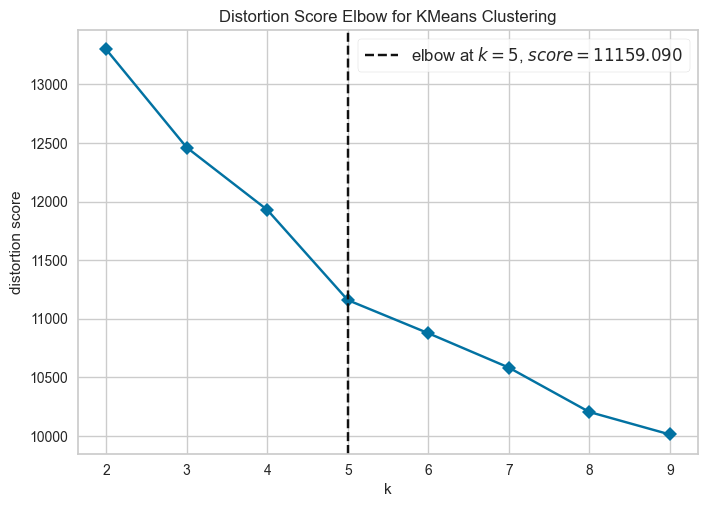

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [122]:
# Elbow Method untuk menentukan jumlah cluster optimal
kmeans_model = KMeans(random_state=42)

visualizer = KElbowVisualizer(
    kmeans_model,
    k=(2, 10),
    metric='distortion',
    timings=False
)

visualizer.fit(df_scaled)
visualizer.show()


In [123]:
# Tentukan jumlah cluster optimal
k_optimal = 5  

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)


Berdasarkan visualisasi Elbow Method, penurunan nilai distortion mulai melandai pada k = 5.
Oleh karena itu, jumlah cluster optimal yang digunakan adalah 5.


In [124]:
joblib.dump(kmeans, "model_clustering.h5")

['model_clustering.h5']

In [125]:
sil_score = silhouette_score(df_scaled, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")


Silhouette Score: 0.1022


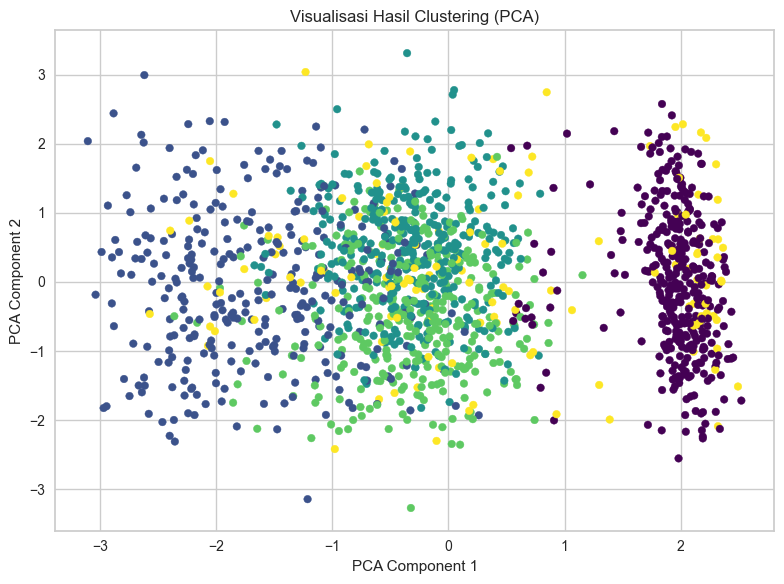

In [126]:
# PCA untuk visualisasi
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='viridis', s=30)
plt.title("Visualisasi Hasil Clustering (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [127]:
joblib.dump(pca, "PCA_model_clustering.h5")


['PCA_model_clustering.h5']

In [128]:
# Tambahkan label cluster ke data hasil preprocessing
df_scaled['Target'] = cluster_labels

In [129]:
# Analisis statistik per cluster (data scaled)
cluster_summary = df_scaled.groupby('Target').agg(['mean', 'min', 'max'])
cluster_summary


TransactionAmount                     PreviousTransactionDate  \
                    mean       min       max                    mean   
Target                                                                 
0              -0.259315 -1.172368  1.578569               -0.015865   
1              -0.244716 -1.171483  1.844941                0.029849   
2              -0.242999 -1.172089  1.616449                0.114350   
3              -0.165706 -1.165100  1.588540               -0.084304   
4               2.221412  1.568598  3.034644               -0.111660   

                           TransactionType            Location  ...  \
             min       max            mean  min  max      mean  ...   
Target                                                          ...   
0      -1.698505  1.708444             0.0  0.0  0.0 -0.009559  ...   
1      -1.695279  1.740707             0.0  0.0  0.0  0.162153  ...   
2      -1.683987  1.737480             0.0  0.0  0.0  0.038591  ...   
3      -1.693665  1.743933             0.0  0.0  0.0 -0.165499  ...   
4      -1.692052  1.593911             0.0  0.0  0.0 -0.043681  ...   

       TransactionDuration LoginAttempts           AccountBalance            \
                       max          mean  min  max           mean       min   
Target                                                                        
0                 2.523393           0.0  0.0  0.0      -0.924464 -1.277599   
1                 2.537436           0.0  0.0  0.0       1.333417  0.032843   
2                 2.509351           0.0  0.0  0.0      -0.206458 -1.280313   
3                 2.481265           0.0  0.0  0.0      -0.024413 -1.278207   
4                 2.368925           0.0  0.0  0.0      -0.124327 -1.283047   

                 TransactionAmount_Bin          
             max                  mean min max  
Target                                          
0       1.206480              1.225989   1   2  
1       2.568818              1.253918   0   2  
2       1.063636              1.267806   1   2  
3       1.509670              1.296736   1   2  
4       2.435806              0.014286   0   2  

[5 rows x 39 columns]

In [130]:
# Simpan data clustering (scaled + Target)
df_scaled.to_csv("data_clustering.csv", index=False)


In [131]:
# Inverse scaling untuk fitur numerik
df_inverse = df_scaled.copy()
df_inverse[numeric_columns] = scaler.inverse_transform(df_scaled[numeric_columns])


In [132]:
# Inverse encoding untuk fitur kategorikal
for col, le in label_encoders.items():
    df_inverse[col] = le.inverse_transform(df_inverse[col].astype(int))


In [133]:
# Analisis deskriptif numerik setelah inverse
numeric_cols = df_inverse.select_dtypes(include=['int64', 'float64']).columns

cluster_summary_numeric = (
    df_inverse
    .groupby('Target')[numeric_cols]
    .agg(['mean', 'min', 'max'])
)

cluster_summary_numeric


TransactionAmount                 CustomerAge              \
                    mean     min     max        mean   min   max   
Target                                                             
0             196.224040    0.26  590.68   23.135593  18.0  31.0   
1             199.357367    0.45  647.85   47.611285  26.0  70.0   
2             199.725840    0.32  598.81   56.512821  26.0  80.0   
3             216.315015    1.82  592.82   52.008902  25.0  80.0   
4             728.650071  588.54  903.19   41.892857  18.0  80.0   

       TransactionDuration              LoginAttempts            \
                      mean   min    max          mean  min  max   
Target                                                            
0               120.488701  13.0  299.0           1.0  1.0  1.0   
1               128.639498  11.0  300.0           1.0  1.0  1.0   
2               109.017094  11.0  298.0           1.0  1.0  1.0   
3               120.738872  10.0  296.0           1.0  1.0  1.0   
4               117.378571  10.0  288.0           1.0  1.0  1.0   

       AccountBalance                    TransactionAmount_Bin          
                 mean      min       max                  mean min max  
Target                                                                  
0         1487.035508   123.24   9716.68              1.225989   1   2  
1        10206.905737  5184.13  14977.99              1.253918   0   2  
2         4259.955214   112.76   9165.02              1.267806   1   2  
3         4963.009288   120.89  10887.59              1.296736   1   2  
4         4577.143214   102.20  14464.30              0.014286   0   2

In [134]:
## Cek Data Inverse
df_inverse.head()

,TransactionAmount,PreviousTransactionDate,TransactionType,Location,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,TransactionAmount_Bin,Target
0,14.09,2023-04-11 16:29:14,Debit,San Diego,162.198.218.92,M015,ATM,70.0,Doctor,81.0,1.0,5112.21,1,2
1,376.24,2023-06-27 16:44:19,Debit,Houston,13.149.61.4,M052,ATM,68.0,Doctor,141.0,1.0,13758.91,2,1
2,126.29,2023-07-10 18:16:08,Debit,Mesa,215.97.143.157,M009,Online,19.0,Student,56.0,1.0,1122.35,1,0
3,184.50,2023-05-05 16:32:11,Debit,Raleigh,200.13.225.150,M002,Online,26.0,Student,25.0,1.0,8569.06,1,0
5,92.15,2023-04-03 17:15:01,Debit,Oklahoma City,117.67.192.211,M054,ATM,18.0,Student,172.0,1.0,781.68,1,0


In [135]:
# Simpan data inverse + Target
df_inverse.to_csv("data_clustering_inverse.csv", index=False)


### Interpretasi Hasil Clustering

Berdasarkan hasil clustering menggunakan algoritma K-Means dengan jumlah cluster optimal sebanyak 5,
serta analisis deskriptif pada data yang telah dikembalikan ke skala aslinya (inverse transform),
diperoleh karakteristik masing-masing cluster sebagai berikut:

**Cluster 0**
Cluster ini memiliki rata-rata TransactionAmount dan AccountBalance yang relatif tinggi
dibandingkan beberapa cluster lainnya. Hal ini menunjukkan kelompok pengguna dengan
aktivitas transaksi yang cukup intens dan nilai saldo yang besar.

**Cluster 1**
Cluster ini menunjukkan rata-rata TransactionAmount yang berada pada tingkat menengah,
dengan AccountBalance yang juga berada pada kisaran menengah.
Kelompok ini dapat merepresentasikan pengguna dengan pola transaksi yang stabil dan reguler.

**Cluster 2**
Cluster ini memiliki rata-rata TransactionAmount yang lebih rendah,
namun dengan AccountBalance yang masih berada pada tingkat menengah.
Hal ini mengindikasikan pengguna yang cenderung jarang melakukan transaksi
atau melakukan transaksi dengan nominal kecil.

**Cluster 3**
Cluster ini ditandai dengan TransactionAmount dan AccountBalance yang relatif rendah.
Kelompok ini mengindikasikan pengguna dengan aktivitas transaksi yang minim
dan saldo akun yang kecil.

**Cluster 4**
Cluster ini menunjukkan karakteristik yang berbeda dari cluster lainnya,
baik dari sisi TransactionAmount maupun AccountBalance.
Perbedaan ini mengindikasikan adanya pola transaksi khusus yang membedakan
cluster ini dari kelompok pengguna lainnya.